In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from glob import glob
from sklearn.metrics import adjusted_mutual_info_score
from tqdm import tqdm
from scipy.spatial.distance import squareform
from igraph import Graph
from igraph import ADJ_MAX
import networkx as nx
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
results = glob('/home/kurmukov/connective_parcellation/concon_processing/model_eval_results/*_cv.csv')

df = pd.read_csv(results[0], index_col=0)
for f in results[1:]:
#     if 'cv' not in f:
#         temp = pd.read_csv(f, index_col=0)
#         df = df.append(temp, ignore_index=True)
    temp = pd.read_csv(f, index_col=0)
    df = df.append(temp, ignore_index=True)

auc_test = df.test_mean
auc_mean = df.cv_mean
n_features = df.non_zero

def fun(x):
    return int(0.5 * (1 + np.sqrt(1 + 8*x)))
df['n_vertices'] = df.n_features.apply(fun)
n_vertices = df.n_vertices

In [3]:
font = {'family' : 'monospace',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
# plt.scatter(n_features, auc_test);
# plt.scatter(n_features[ind], auc_test[ind], c='r')

In [5]:
# s = 10
# ind = np.array(list(df.query(f'sparsity == {s}').index))
# plt.scatter(n_vertices[ind], auc_test[ind], s= 10);
# ind = np.array(list(df.query(f'ensemble == "HE" and level == "3" and sparsity == {s}').index))
# plt.scatter(n_vertices[ind], auc_test[ind], c='r', s = 10, label='$HE_3$')
# ind = np.array(list(df.query(f'ensemble == "Desikan_aparc" and level == "0" and sparsity == {s}').index))
# plt.scatter(n_vertices[ind], auc_test[ind], c='g', s = 10, label='$Desikan$')
# ind = np.array(list(df.query(f'ensemble == "Aver" and level == "3" and sparsity == {s}').index))
# plt.scatter(n_vertices[ind], auc_test[ind], c='orange', s = 10, label='$Aver_3$')
# plt.legend();

In [6]:
res = []
for e, l in zip(df['ensemble'], df['level']):
    if 'Desikan' in e:
        res.append('$Desikan$')
    elif 'Destrieux' in e:
        res.append('$Destrieux$')
    else:
        res.append(f'${e}_{l}$' )
df['ensemble_level'] = res

In [8]:
df.sort_values(by='test_mean', ascending=False).drop_duplicates(subset=['ensemble', 'level'])

,cv_mean,cv_std,test_mean,test_std,C,ensemble,level,sparsity,n_features,non_zero,n_vertices,ensemble_level
84,0.897504,0.049363,0.884529,0.042939,400.0,Aver,3,50,4005,1198,90,$Aver_3$
79,0.881245,0.053428,0.877029,0.046335,180.0,HE,3,100,3570,838,85,$HE_3$
107,0.891287,0.047256,0.868985,0.066569,20.0,Destrieux_aparc2009,0,80,10878,653,148,$Destrieux$
98,0.866271,0.053954,0.865943,0.055011,500.0,Desikan_aparc,0,90,2278,950,68,$Desikan$
67,0.817683,0.064972,0.834455,0.056415,180.0,Aver,2,80,528,232,33,$Aver_2$
53,0.800529,0.068082,0.804723,0.073091,500.0,HE,2,40,496,265,32,$HE_2$
47,0.739076,0.079185,0.735379,0.067785,0.3,CSPA,3,80,45,28,10,$CSPA_3$
39,0.731941,0.082331,0.728688,0.042972,0.3,CSPA,2,100,28,14,8,$CSPA_2$
3,0.685999,0.080183,0.693385,0.114067,200.0,HE,1,40,28,15,8,$HE_1$
29,0.690081,0.085492,0.681787,0.088651,0.3,Aver,1,100,28,12,8,$Aver_1$


In [218]:
df.groupby(['ensemble', 'level'])['cv_mean'].agg(['median','mean', 'std'])

median      mean       std
ensemble            level                              
Aver                1      0.670689  0.673233  0.016771
                    2      0.811354  0.805297  0.014800
                    3      0.848240  0.862675  0.027878
CSPA                1      0.645664  0.648092  0.025379
                    2      0.695826  0.701379  0.026500
                    3      0.683424  0.686284  0.029227
Desikan_aparc       0      0.846931  0.852454  0.012231
Destrieux_aparc2009 0      0.863799  0.866619  0.023565
HE                  1      0.654254  0.660447  0.020836
                    2      0.796622  0.791286  0.018659
                    3      0.848420  0.853685  0.024492

In [127]:
df.groupby('ensemble_level')['n_vertices'].agg(['mean', 'std'])

,mean,std
ensemble_level,,
$Aver_1$,8.1,0.316228
$Aver_2$,32.8,0.788811
$Aver_3$,88.7,2.790858
$CSPA_1$,6.9,0.316228
$CSPA_2$,7.9,0.316228
$CSPA_3$,10.0,1.154701
$Desikan$,68.0,0.000000
$Destrieux$,148.0,0.000000
$HE_1$,8.4,0.516398


In [105]:
sns.set_style("whitegrid")

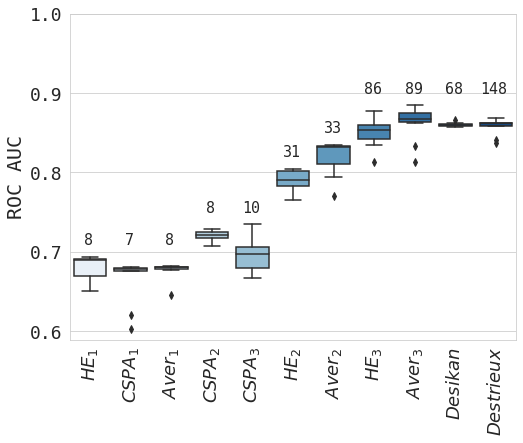

In [189]:
f, ax = plt.subplots(figsize=(8,6))
eps=0.3
font = {'family' : 'monospace',
        'size'   : 20}
sns.boxplot(data=df, x='ensemble_level', y='test_mean', palette='Blues')
ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)
# ax.set_xlabel('Parcellation', fontdict=font)
ax.set_xlabel('')
ax.set_ylabel('ROC AUC', fontdict=font)
ax.set_yticks([.6, .7, .8, .9, 1.]);
font = {'family' : 'monospace',
        'size'   : 15}
for x, y, s in zip(np.array([0-.15,     1-.15,   2-.15,   3-.15,
                             4-.25,   5-.25,   6-.25,  7-.25,  8-.25,  9-.25, 10-.4]),
                   [.71, .71, .71, .75, .75, .82, .85, .9, .9, .9, .9],
                   ['8', '7', '8', '8', '10','31','33','86','89','68', '148' ]):
    ax.text(x,y,s,fontdict=font)


In [97]:
kl = pd.read_csv(glob('/home/kurmukov/connective_parcellation/concon_processing/kl_results/*.csv')[0], index_col=0)
for s in glob('/home/kurmukov/connective_parcellation/concon_processing/kl_results/*.csv')[1:]:
    kl = kl.append(pd.read_csv(s, index_col=0), ignore_index=True)

In [98]:
kl.agg(['mean', 'std'])

,HE_1_10,HE_2_10,HE_3_10,CSPA_1_10,CSPA_2_10,CSPA_3_10,Aver_1_10,Aver_2_10,Aver_3_10,desikan_average_none_none,destrieux_average_none_none
mean,12.675058,9.332111,7.361693,13.748081,12.837877,12.553286,12.818889,9.592630,7.837329,9.155655,7.178147
std,0.771609,0.585987,0.466873,0.848904,0.785852,0.808123,0.790978,0.592991,0.497693,0.538750,0.417595


In [99]:
kl.columns = ['$HE_1$', '$HE_2$', '$HE_3$',
              '$CSPA_1$', '$CSPA_2$', '$CSPA_3$',
             '$Aver_1$', '$Aver_2$', '$Aver_3$',
              'Desikan', 'Destrieux']

In [100]:
KL = pd.DataFrame(kl.values.T.reshape(-1), columns=['KL divergence'])
KL['Parcellation'] = np.concatenate([[p]*426 for p in ['$HE_1$', '$HE_2$', '$HE_3$',
              '$CSPA_1$', '$CSPA_2$', '$CSPA_3$',
             '$Aver_1$', '$Aver_2$', '$Aver_3$',
              '$Desikan$', '$Destrieux$']])

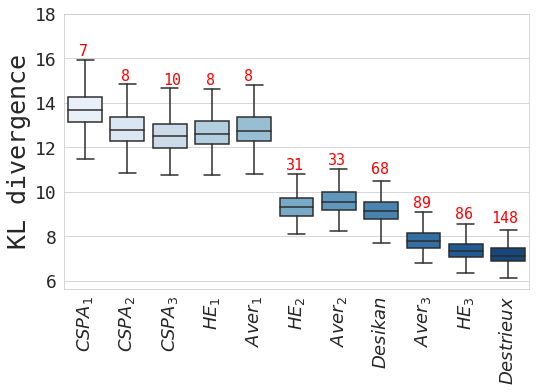

In [106]:
f, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=KL, x = 'Parcellation', y='KL divergence', ax=ax,
           order = ['$CSPA_1$', '$CSPA_2$', '$CSPA_3$',
                    '$HE_1$', '$Aver_1$', '$HE_2$', '$Aver_2$',
                     '$Desikan$', '$Aver_3$', '$HE_3$', '$Destrieux$'], showfliers=False, palette='Blues')
ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)

ax.set_xlabel('')

font = {'family' : 'monospace',
        'size'   : 15}
for x, y, s in zip(np.array([0-.15,     1-.15,   2-.15,   3-.15,
                             4-.25,   5-.25,   6-.25,  7-.25,  8-.25,  9-.25, 10-.4]),
                   [16.1, 15, 14.8, 14.8,15, 11, 11.2, 10.8, 9.3, 8.8, 8.6],
                   ['7', '8', '10', '8', '8','31','33','68','89','86', '148' ]):
    ax.text(x,y,s,fontdict=font, c='r')
ax.set_yticks([6, 8, 10, 12, 14, 16, 18]);
f.tight_layout()
f.savefig(fname='/home/kurmukov/pics/KLdiv.png', transparent=True, dpi=300)

In [103]:
df.groupby('ensemble_level')['n_vertices'].agg(['mean', 'std'])

,mean,std
ensemble_level,,
$Aver_1$,8.1,0.316228
$Aver_2$,32.8,0.788811
$Aver_3$,88.7,2.790858
$CSPA_1$,6.9,0.316228
$CSPA_2$,7.9,0.316228
$CSPA_3$,10.0,1.154701
$Desikan$,68.0,0.000000
$Destrieux$,148.0,0.000000
$HE_1$,8.4,0.516398


In [ ]:
a = [
    [1, 1, 1],
    [2, 2, 2]
]

In [190]:
2 / 86

0.023255813953488372

# Reproduce Clf results for boxplots

In [15]:
from scipy.spatial.distance import squareform
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sys import argv

def get_X_y(con_folder):
#     '/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/HE_level3/100/'
    connectomes = sorted(glob(f'{con_folder}*.npy'))

    subject_ids = []
    edges = []
    for c in connectomes:
        sid = int(c.split('/')[-1].split('.')[0])
        if sid != 142626:
            subject_ids.append(sid)
            adj = np.load(c)
            edges.append(squareform(adj))

    meta = pd.read_csv('/home/kurmukov/connective_parcellation_old/HCP/old_code/unrestricted_hcp_freesurfer.csv')
    meta['1_0_gender'] = meta['Gender'].map({'F':0,'M':1})
    sex = dict(zip(meta['Subject'], meta['1_0_gender']))
    y=[sex.get(s) for s in subject_ids]

    y = np.array(y)
    X = np.array(edges)
    return X, y

def model_eval(X, y, random_state=10):
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    model = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1',
                                                               random_state=random_state,
                                                               solver='liblinear'))
    
    inner_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=random_state)
    score = make_scorer(roc_auc_score, needs_proba=True)
    params={
        
    'logisticregression__C': [0.001, 0.003, 0.01, 0.03,
                              0.1,   0.3,   1,    5,
                              10,    20,    50,   100,
                              150,   180,   200,  220,
                              250,   300,   400,  500]
    }
    aucs_test = []
    for train, test in outer_cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        
        gs = GridSearchCV(model,
                          param_grid=params,
                          cv = inner_cv,
                          scoring=score,
                          n_jobs=20,
                          iid=False,
                          refit=True)


        gs.fit(X_train, y_train)
        y_pred = gs.predict_proba(X_test)
        aucs_test.append(roc_auc_score(y_test, y_pred[:, 1]))
    
    return gs, aucs_test

In [10]:
df2 = df.sort_values(by='test_mean', ascending=False).drop_duplicates(subset=['ensemble', 'level'])

In [23]:
d = dict([(f'{e}_{l}', s) for e, l, s in zip(df2['ensemble'], df2['level'], df2['sparsity'])])
d2 = dict([(f'{e}_{l}', c) for e, l, c in zip(df2['ensemble'], df2['level'], df2['C'])])

In [19]:
d['Destrieux_aparc2009'] = d['Destrieux_aparc2009_0']
d['Desikan_aparc'] = d['Desikan_aparc_0']
d

{'Aver_3': 50,
 'HE_3': 100,
 'Destrieux_aparc2009_0': 80,
 'Desikan_aparc_0': 90,
 'Aver_2': 80,
 'HE_2': 40,
 'CSPA_3': 80,
 'CSPA_2': 100,
 'HE_1': 40,
 'Aver_1': 100,
 'CSPA_1': 60,
 'Destrieux_aparc2009': 80,
 'Desikan_aparc': 90}

In [24]:
d2['Destrieux_aparc2009'] = d2['Destrieux_aparc2009_0']
d2['Desikan_aparc'] = d2['Desikan_aparc_0']
d2

{'Aver_3': 400.0,
 'HE_3': 180.0,
 'Destrieux_aparc2009_0': 20.0,
 'Desikan_aparc_0': 500.0,
 'Aver_2': 180.0,
 'HE_2': 500.0,
 'CSPA_3': 0.3,
 'CSPA_2': 0.3,
 'HE_1': 200.0,
 'Aver_1': 0.3,
 'CSPA_1': 0.3,
 'Destrieux_aparc2009': 20.0,
 'Desikan_aparc': 500.0}

In [20]:
data = dict()
for ensemble in tqdm(['HE', 'CSPA', 'Aver']):
    for level in [1, 2, 3]:
        sparsity = d[f'{ensemble}_{level}']
        subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/{ensemble}_level{level}/{sparsity}/'
        X, y = get_X_y(subject_folder)
        data[f'{ensemble}_{level}'] = (X, y)
for parc in tqdm(['Desikan_aparc', 'Destrieux_aparc2009']):
    sparsity = d[parc]
    subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/{parc}_resolution/{sparsity}/'
    X, y = get_X_y(subject_folder)
    data[parc] = (X, y)

100%|██████████| 2/2 [00:06<00:00,  3.71s/it]


In [25]:
data.keys()

dict_keys(['HE_1', 'HE_2', 'HE_3', 'CSPA_1', 'CSPA_2', 'CSPA_3', 'Aver_1', 'Aver_2', 'Aver_3', 'Desikan_aparc', 'Destrieux_aparc2009'])

In [28]:
# C = 1
random_state=10
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
model = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1',
                                                           random_state=random_state,
                                                           solver='liblinear'))
auc = dict()
for key, val in tqdm(data.items()):
    X, y = val
    auc[key] = []
    for train, test in outer_cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        auc[key].append(roc_auc_score(y_test, y_pred[:, 1]))

100%|██████████| 11/11 [00:10<00:00,  2.13s/it]


In [30]:
for key,val in auc.items():
    print(key, f'{np.round(np.mean(val), 3)}', f'{np.round(np.std(val), 3)}')

HE_1 0.692 0.112
HE_2 0.799 0.066
HE_3 0.846 0.06
CSPA_1 0.68 0.119
CSPA_2 0.722 0.046
CSPA_3 0.743 0.072
Aver_1 0.685 0.095
Aver_2 0.84 0.052
Aver_3 0.845 0.047
Desikan_aparc 0.806 0.05
Destrieux_aparc2009 0.838 0.061


In [34]:
random_state=10
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
model = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1',
                                                           random_state=random_state,
                                                           solver='liblinear'))
auc = dict()
for key, val in tqdm(data.items()):
    X, y = val
    C = d2[key]
    auc[key] = []
    model.set_params(**{'logisticregression__C': C})
    for train, test in outer_cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        auc[key].append(roc_auc_score(y_test, y_pred[:, 1]))

100%|██████████| 11/11 [00:10<00:00,  2.21s/it]


In [35]:
for key,val in auc.items():
    print(key, f'{np.round(np.mean(val), 3)}', f'{np.round(np.std(val), 3)}')

HE_1 0.693 0.114
HE_2 0.797 0.065
HE_3 0.877 0.048
CSPA_1 0.682 0.114
CSPA_2 0.729 0.043
CSPA_3 0.736 0.071
Aver_1 0.684 0.09
Aver_2 0.839 0.053
Aver_3 0.886 0.046
Desikan_aparc 0.866 0.055
Destrieux_aparc2009 0.845 0.064


In [41]:
np.concatenate(list(auc.values()))

array([0.77149321, 0.78506787, 0.42307692, 0.60859729, 0.78280543,
       0.79864253, 0.58823529, 0.75961538, 0.72      , 0.6875    ,
       0.76244344, 0.8280543 , 0.67873303, 0.8438914 , 0.80542986,
       0.90723982, 0.85520362, 0.73557692, 0.8175    , 0.735     ,
       0.90271493, 0.81900452, 0.80542986, 0.92533937, 0.89366516,
       0.89366516, 0.92081448, 0.89182692, 0.925     , 0.7975    ,
       0.73529412, 0.72850679, 0.49547511, 0.47511312, 0.76923077,
       0.72171946, 0.66968326, 0.87740385, 0.695     , 0.655     ,
       0.79411765, 0.72850679, 0.68325792, 0.63348416, 0.77828054,
       0.73529412, 0.73076923, 0.73317308, 0.75      , 0.72      ,
       0.62669683, 0.76470588, 0.76923077, 0.74208145, 0.7918552 ,
       0.760181  , 0.73303167, 0.58894231, 0.8425    , 0.74      ,
       0.76923077, 0.75339367, 0.45475113, 0.61538462, 0.72624434,
       0.75791855, 0.65158371, 0.74038462, 0.7025    , 0.67      ,
       0.84615385, 0.84841629, 0.75113122, 0.88461538, 0.80090

In [42]:
AUC = pd.DataFrame()
AUC['test_mean'] = np.concatenate(list(auc.values()))
AUC['ensemble_level'] = ['$HE_1$']*10 + ['$HE_2$']*10 + ['$HE_3$']*10 +\
                        ['$CSPA_1$']*10 + ['$CSPA_2$']*10 + ['$CSPA_3$']*10 +\
                        ['$Aver_1$']*10 + ['$Aver_2$']*10 + ['$Aver_3$']*10 +\
                        ['$Desikan$']*10 + ['$Destrieux$']*10                           


In [74]:
sns.set_style("whitegrid")

In [108]:
font = {'family' : 'monospace',
        'size'   : 25}
plt.rc('font', **font)

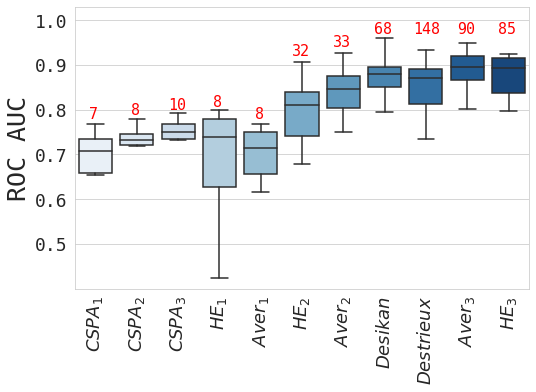

In [109]:
f, ax = plt.subplots(figsize=(8,6))
eps=0.07
# font = {'family' : 'monospace',
#         'size'   : 20}
sns.boxplot(data=AUC,
            x='ensemble_level',
            y='test_mean',
            palette='Blues',
            order = ['$CSPA_1$', '$CSPA_2$', '$CSPA_3$',
                    '$HE_1$', '$Aver_1$', '$HE_2$', '$Aver_2$',
                     '$Desikan$', '$Destrieux$', '$Aver_3$', '$HE_3$'],
           showfliers=False)



ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('')
ax.set_ylabel('ROC AUC', fontdict=font)
ax.set_ylim(0.4, 1.03)
ax.set_yticks([.5, .6, .7, .8, .9, 1.]);
font = {'family' : 'monospace',
        'size'   : 15}
for x, y, s in zip(np.array([0-.15,     1-.15,   2-.25,   3-.15,
                             4-.15,   5-.25,   6-.25,  7-.25,  8-.32,  9-.25, 10-.25]),
                   np.array([.71, .71+.01, .71+.02, .75-.012, .75-.04, .82+.03, .85+.02, .9, .9, .9, .9])+eps,
                   ['7', '8', '10', '8', '8','32','33','68','148','90', '85' ]):
    ax.text(x,y,s,fontdict=font, c='r')
f.tight_layout()
f.savefig(fname='/home/kurmukov/pics/aucs.png', transparent=True, dpi=300)